In [1]:
import time
import pickle
import math
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn import preprocessing

In [2]:
SUBMISSION = False
SUBMISSION_FILENAME = 'submission.csv'
TEST_FILENAME = 'test.csv'

In [3]:
target_playlists = pd.read_csv('../datasets/target_playlists.csv', sep='\t')
target_tracks = pd.read_csv('../datasets/target_tracks.csv', sep='\t')
tracks_final = pd.read_csv('../datasets/tracks_final.csv', sep='\t')
playlists_final = pd.read_csv('../datasets/playlists_final.csv', sep='\t')
train_final = pd.read_csv('../datasets/train_final.csv', sep='\t')

print('Successfully read data')

Successfully read data


In [4]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, scipy.sparse.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, scipy.sparse.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, scipy.sparse.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, scipy.sparse.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, scipy.sparse.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, scipy.sparse.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, scipy.sparse.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [5]:
def is_relevant(recommendation_item, validation_set):
    validation_item = validation_set.loc[validation_set['playlist_id'] == recommendation_item['playlist_id']]
    recommendation_item['recommendation'] = pd.Series(recommendation_item['recommendation'])\
                                                .isin(list(validation_item['track_id']))
    return recommendation_item


def precision(recommended_items_relevance):
    precision_scores = recommended_items_relevance.sum(axis=1) / recommended_items_relevance.shape[1]
    return precision_scores.mean()


def mAP(recommended_items_relevance):
    p_at_k = recommended_items_relevance.cumsum(axis=1) / (1 + np.arange(recommended_items_relevance.shape[1]))
    recommended_items_mAP = p_at_k.sum(axis=1) / recommended_items_relevance.shape[1]
    return recommended_items_mAP.mean()


def evaluate_recommendations(recommended_items, validation_set):
    items_relevance = recommended_items.apply(lambda recommendation_item: is_relevant(recommendation_item, validation_set), axis=1)
    recommended_items_relevance = pd.DataFrame(list(items_relevance['recommendation']), index=items_relevance['recommendation'].index)
    precision_score = precision(recommended_items_relevance)
    mAP_score = mAP(recommended_items_relevance)
    return precision_score, mAP_score

def evaluate(recommended_items, validation_set):
    print('Evaluating...')
    begin = time.time()
    precision_score, mAP_score = evaluate_recommendations(recommended_items, validation_set)
    print('Precision: {0:.{digits}f}, mAP: {1:.{digits}f}, took {2:.{digits}f}s'
          .format(precision_score, mAP_score, time.time() - begin, digits=5))

In [6]:
def str_tags_to_list(str_tags):
    if str_tags == '[]':
        return []
    return list(map(int, str_tags.replace('[', '').replace(']', '').replace(' ', '').split(',')))


def str_album_to_int(album):
    if album == '[]' or album == '[None]':
        return -1
    return int(album.replace('[', '').replace(']', ''))

In [7]:
def get_weight(i):
    if i == 0:
        return 2.5
    if i == 1:
        return 2.0
    if i == 2:
        return 1.6
    if i == 3:
        return 1.2
    if i == 4:
        return 1.0

def get_tracks_tags(track_final):
    track_tags_list = str_tags_to_list(track_final['tags'])
    return [[track_final['track_id'], track_tag, get_weight(i)] for i, track_tag in enumerate(track_tags_list)]

tracks_tags = pd.concat([pd.DataFrame(data=get_tracks_tags(track_final), columns=['track_id', 'tag', 'weight']) for index, track_final in tracks_final.iterrows()])
print('tracks_tags {}'.format(tracks_tags.shape))
print(tracks_tags.head(6))

tracks_tags (483501, 3)
  track_id     tag  weight
0  2972914   54087     2.5
1  2972914    1757     2.0
2  2972914    1718     1.6
3  2972914  116712     1.2
4  2972914  189631     1.0
0  2750239  189631     2.5


In [8]:
def get_track_album(track_final):
    track_album = str_album_to_int(track_final['album'])
    return [[track_final['track_id'], track_album]]

tracks_albums = pd.concat([pd.DataFrame(data=get_track_album(track_final), columns=['track_id', 'album']) for index, track_final in tracks_final.iterrows()])
# Remove tracks without album
tracks_albums = tracks_albums[tracks_albums.album != -1]
print('tracks_albums {}'.format(tracks_albums.shape))
print(tracks_albums.head(6))

tracks_albums (73244, 2)
   track_id  album
0   2972914      7
0   2750239      8
0   1550729      9
0   2169950      9
0   2256817      9
0   2561768     26


In [9]:
tracks_artist = pd.DataFrame()
tracks_artist['track_id'] = tracks_final['track_id']
tracks_artist['artist_id'] = tracks_final['artist_id']
print('tracks_artist {}'.format(tracks_artist.shape))
print(tracks_artist.head(6))

tracks_artist (100000, 2)
   track_id  artist_id
0   2972914        144
1   2750239        246
2   1550729        144
3   2169950        144
4   1903709        144
5   2256817        144


In [10]:
def get_playlist_titles(playlist_final):
    playlist_tags_list = str_tags_to_list(playlist_final['title'])
    return [[playlist_final['playlist_id'], playlist_tag] for playlist_tag in playlist_tags_list]

playlist_titles = pd.concat([pd.DataFrame(data=get_playlist_titles(playlist_final), columns=['playlist_id', 'title']) for index, playlist_final in playlists_final.iterrows()])
print('playlist_titles {}'.format(playlist_titles.shape))
print(playlist_titles.head(6))

playlist_titles (108382, 2)
  playlist_id  title
0      644838  12727
0     3120683    183
0     4278112  12389
1     4278112  18698
2     4278112  18925
3     4278112  11695


In [11]:
playlist_owner = pd.DataFrame()
playlist_owner['playlist_id'] = playlists_final['playlist_id']
playlist_owner['owner'] = playlists_final['owner']
print('playlist_owner {}'.format(playlist_owner.shape))
print(playlist_owner.head(6))

playlist_owner (57561, 2)
   playlist_id  owner
0       644838  41504
1      7577564  41504
2      3120683  44542
3      4278112  44542
4      8656823  44542
5     10961458  44542


In [12]:
print('Data info:')
print('Tracks with tags count: {}'.format(tracks_tags['track_id'].nunique()))
print('Unique tags count: {}\n'.format(tracks_tags['tag'].nunique()))

print('Tracks with album count: {}'.format(tracks_albums['track_id'].nunique()))
print('Unique album count: {}\n'.format(tracks_albums['album'].nunique()))

print('Tracks with artists count: {}'.format(tracks_artist['track_id'].nunique()))
print('Unique artists count: {}\n'.format(tracks_artist['artist_id'].nunique()))

print('Playlists with title count: {}'.format(playlist_titles['playlist_id'].nunique()))
print('Unique titles count: {}\n'.format(playlist_titles['title'].nunique()))

print('Playlist with owner count: {}'.format(playlist_owner['playlist_id'].nunique()))
print('Unique owner count: {}\n'.format(playlist_owner['owner'].nunique()))

print('Unique tracks count: {}'.format(tracks_final['track_id'].nunique()))
print('Unique playlist count: {}'.format(playlists_final['playlist_id'].nunique()))
print('Target tracks count: {}'.format(target_tracks['track_id'].nunique()))
print('Target playlists count: {}'.format(target_playlists['playlist_id'].nunique()))

Data info:
Tracks with tags count: 97211
Unique tags count: 31900

Tracks with album count: 73244
Unique album count: 27604

Tracks with artists count: 100000
Unique artists count: 17536

Playlists with title count: 52384
Unique titles count: 21064

Playlist with owner count: 57561
Unique owner count: 15264

Unique tracks count: 100000
Unique playlist count: 57561
Target tracks count: 32195
Target playlists count: 10000


In [13]:
track_id_le = preprocessing.LabelEncoder()
track_id_le.fit(list(tracks_final['track_id']))
print('track_id_le classes: {}'.format(len(track_id_le.classes_)))

playlist_id_le = preprocessing.LabelEncoder()
playlist_id_le.fit(list(playlists_final['playlist_id']))
print('playlist_id_le classes: {}'.format(len(playlist_id_le.classes_)))

title_le = preprocessing.LabelEncoder()
title_le.fit(list(playlist_titles['title']))
print('title_le classes: {}'.format(len(title_le.classes_)))

owner_le = preprocessing.LabelEncoder()
owner_le.fit(list(playlist_owner['owner']))
print('owner_le classes: {}'.format(len(owner_le.classes_)))

tags_le = preprocessing.LabelEncoder()
tags_le.fit(list(tracks_tags['tag']))
print('tags_le classes: {}'.format(len(tags_le.classes_)))

album_le = preprocessing.LabelEncoder()
album_le.fit(list(tracks_albums['album']))
print('album_le classes: {}'.format(len(album_le.classes_)))

artist_le = preprocessing.LabelEncoder()
artist_le.fit(list(tracks_artist['artist_id']))
print('artist_le classes: {}'.format(len(artist_le.classes_)))

track_id_le classes: 100000
playlist_id_le classes: 57561
title_le classes: 21064
owner_le classes: 15264
tags_le classes: 31900
album_le classes: 27604
artist_le classes: 17536


In [14]:
# Playlist and tracks that belong to them
target_playlists_and_tracks = pd.merge(target_playlists, train_final, on='playlist_id')
print('target_playlists_and_tracks {}'.format(target_playlists_and_tracks.shape))
print(target_playlists_and_tracks.head(10))

target_playlists_and_tracks (362661, 2)
   playlist_id  track_id
0     10024884   2879006
1     10024884   1532328
2     10024884   3027673
3     10024884   3236144
4     10024884   1563134
5     10024884    435345
6     10024884    353291
7     10024884    247331
8     10024884    161455
9     10024884   3338954


In [15]:
def split_training_data(train_final, target_playlists_and_tracks, random_state):
    validation_set = target_playlists_and_tracks.groupby(['playlist_id'])\
                        .apply(lambda x: x.sample(n=3, random_state=random_state))\
                        .reset_index(drop=True)
    df_concat = pd.concat([train_final, validation_set])
    training_set = df_concat.drop_duplicates(keep=False)
    return training_set, validation_set

# Split dataset - from all target playlists remove randomly 3 tracks
training_set, validation_set = split_training_data(train_final, target_playlists_and_tracks, random_state=0)
test_target_tracks = validation_set['track_id'].drop_duplicates(keep='first').to_frame()
test_target_tracks['transformed_track_id'] = track_id_le.transform(list(test_target_tracks['track_id']))
target_tracks['transformed_track_id'] = track_id_le.transform(list(target_tracks['track_id']))

training_set['transformed_track_id'] = track_id_le.transform(list(training_set['track_id']))
training_set['transformed_playlist_id'] = playlist_id_le.transform(list(training_set['playlist_id']))
target_playlists['transformed_playlist_id'] = playlist_id_le.transform(list(target_playlists['playlist_id']))

train_final['transformed_track_id'] = track_id_le.transform(list(train_final['track_id']))
train_final['transformed_playlist_id'] = playlist_id_le.transform(list(train_final['playlist_id']))

print('train_final: {}'.format(train_final.shape))
print(train_final.head(5))
print('training_set: {}'.format(training_set.shape))
print(training_set.head(5))
print('validation_set: {}'.format(validation_set.shape))
print(validation_set.head(5))
print('test_target_tracks: {}'.format(test_target_tracks.shape))
print(test_target_tracks.head(5))

train_final: (1040522, 4)
   playlist_id  track_id  transformed_track_id  transformed_playlist_id
0      3271849   2801526                 71058                     8890
1      5616275    727878                 19741                    22426
2     11267488   2805283                 71298                    54743
3     10103900   1515105                 36851                    46970
4      3836898   2945623                 76310                    11967
training_set: (1010522, 4)
   playlist_id  track_id  transformed_track_id  transformed_playlist_id
0      3271849   2801526                 71058                     8890
1      5616275    727878                 19741                    22426
2     11267488   2805283                 71298                    54743
3     10103900   1515105                 36851                    46970
4      3836898   2945623                 76310                    11967
validation_set: (30000, 2)
   playlist_id  track_id
0         7614   2141817
1     

In [16]:
unique_tracks_count = tracks_final['track_id'].nunique()

playlist_titles['transformed_playlist_id'] = playlist_id_le.transform(list(playlist_titles['playlist_id']))
playlist_titles['transformed_title_id'] = list(map(lambda x: x + unique_tracks_count,\
                                                   title_le.transform(list(playlist_titles['title']))))
print('playlist_titles')
print(playlist_titles.head(4))

playlist_owner['transformed_playlist_id'] = playlist_id_le.transform(list(playlist_owner['playlist_id']))
playlist_owner['transformed_owner'] = list(map(lambda x: x + unique_tracks_count + len(title_le.classes_),\
                                                   owner_le.transform(list(playlist_owner['owner']))))
print('playlist_owner')
print(playlist_owner.head(4))

tracks_tags['transformed_track_id'] = track_id_le.transform(list(tracks_tags['track_id']))
tracks_tags['transformed_tag'] = tags_le.transform(list(tracks_tags['tag']))
print('tracks_tags')
print(tracks_tags.head(3))

tracks_albums['transformed_track_id'] = track_id_le.transform(list(tracks_albums['track_id']))
tracks_albums['transformed_album'] = list(map(lambda x: x + len(tags_le.classes_),\
                                  album_le.transform(list(tracks_albums['album']))))
print('tracks_albums')
print(tracks_albums.head(3))

tracks_artist['transformed_track_id'] = track_id_le.transform(list(tracks_artist['track_id']))
tracks_artist['transformed_artist_id'] = list(map(lambda x: x + len(tags_le.classes_) + len(album_le.classes_),\
                                                  artist_le.transform(list(tracks_artist['artist_id']))))
print('tracks_artist')
print(tracks_artist.head(3))

playlist_titles
  playlist_id  title  transformed_playlist_id  transformed_title_id
0      644838  12727                     2514                112727
0     3120683    183                     7829                100183
0     4278112  12389                    14708                112389
1     4278112  18698                    14708                118698
playlist_owner
   playlist_id  owner  transformed_playlist_id  transformed_owner
0       644838  41504                     2514             132679
1      7577564  41504                    35844             132679
2      3120683  44542                     7829             135702
3      4278112  44542                    14708             135702
tracks_tags
  track_id    tag  weight  transformed_track_id  transformed_tag
0  2972914  54087     2.5                 77187             6683
1  2972914   1757     2.0                 77187              257
2  2972914   1718     1.6                 77187              254
tracks_albums
   track_id  

In [17]:
# urm_with_params_ones = np.ones(training_set.shape[0] + playlist_titles.shape[0] + playlist_owner.shape[0])
training_set_v = np.ones(training_set.shape[0]) * 1.0
playlist_titles_v = np.ones(playlist_titles.shape[0]) * 1.0
playlist_owner_v = np.ones(playlist_owner.shape[0]) * 1.0
urm_with_params_values = np.append(training_set_v, np.append(playlist_titles_v, playlist_owner_v))
urm_with_params_ones = np.ones(train_final.shape[0] + playlist_titles.shape[0] + playlist_owner.shape[0])
print('urm_with_params_values shape: {}, vector: {}'.format(urm_with_params_values.shape, urm_with_params_values))

URM_with_params = scipy.sparse.coo_matrix((urm_with_params_ones, (list(train_final['transformed_playlist_id']) + list(playlist_titles['transformed_playlist_id']) + list(playlist_owner['transformed_playlist_id']),
                                                                    list(train_final['transformed_track_id']) + list(playlist_titles['transformed_title_id']) + list(playlist_owner['transformed_owner']))))

# URM_with_params = scipy.sparse.coo_matrix((urm_with_params_values, (list(training_set['transformed_playlist_id']) + list(playlist_titles['transformed_playlist_id']) + list(playlist_owner['transformed_playlist_id']),
#                                                                     list(training_set['transformed_track_id']) + list(playlist_titles['transformed_title_id']) + list(playlist_owner['transformed_owner']))))
URM_with_params = URM_with_params.tocsr()

print(URM_with_params.shape)
tracks_per_playlist = (URM_with_params > 0).sum(axis=1)
playlist_per_track = (URM_with_params > 0).sum(axis=0)

print('tracks_per_playlist.shape {}'.format(tracks_per_playlist.shape))
print('playlist_per_track.shape {}'.format(playlist_per_track.shape))

urm_with_params_values shape: (1176465,), vector: [ 1.  1.  1. ...,  1.  1.  1.]
(57561, 136328)
tracks_per_playlist.shape (57561, 1)
playlist_per_track.shape (1, 136328)


In [18]:
# urm_ones = np.ones(training_set.shape[0])
urm_ones = np.ones(train_final.shape[0])
print('urm_ones shape: {}, vector: {}'.format(urm_ones.shape, urm_ones))

URM = scipy.sparse.coo_matrix((urm_ones, (list(train_final['transformed_track_id']),
                                          list(train_final['transformed_playlist_id']))))

# URM = scipy.sparse.coo_matrix((urm_ones, (list(training_set['transformed_track_id']),
#                                           list(training_set['transformed_playlist_id']))))
print(URM.shape)

urm_ones shape: (1040522,), vector: [ 1.  1.  1. ...,  1.  1.  1.]
(100000, 57561)


In [19]:
print('tracks_tags.shape {}'.format(tracks_tags.shape))
print('tracks_albums.shape {}'.format(tracks_albums.shape))
print('tracks_artist.shape {}'.format(tracks_artist.shape))

tracks_albums_v = np.ones(tracks_albums.shape[0])
tracks_artist_v = np.ones(tracks_artist.shape[0])
values = np.append(tracks_tags['weight'], np.append(tracks_albums_v, tracks_artist_v))
print('values shape: {}, vector: {}'.format(values.shape, values))

ICM = scipy.sparse.coo_matrix((values, (list(tracks_tags['transformed_track_id']) + list(tracks_albums['transformed_track_id']) + list(tracks_artist['transformed_track_id']),\
                                        list(tracks_tags['transformed_tag']) + list(tracks_albums['transformed_album']) + list(tracks_artist['transformed_artist_id']))))

print(ICM.shape)
features_per_item = (ICM > 0).sum(axis=1)
items_per_feature = (ICM > 0).sum(axis=0)

print('features_per_item.shape {}'.format(features_per_item.shape))
print('items_per_feature.shape {}'.format(items_per_feature.shape))

tracks_tags.shape (483501, 5)
tracks_albums.shape (73244, 4)
tracks_artist.shape (100000, 4)
values shape: (656745,), vector: [ 2.5  2.   1.6 ...,  1.   1.   1. ]
(100000, 77040)
features_per_item.shape (100000, 1)
items_per_feature.shape (1, 77040)


In [20]:
# num_tot_playlist = URM_with_params.shape[0]
# IDF = np.array(np.log(num_tot_playlist / (playlist_per_track + 1)))[0]
# URM_with_params_idf = URM_with_params.copy()
# # compute the number of non-zeros in each col
# # NOTE: this works only if X is instance of sparse.csc_matrix
# col_nnz = np.diff(check_matrix(URM_with_params_idf, 'csc').indptr)
# print(col_nnz.shape)
# print(URM_with_params_idf.shape)
# print(IDF.shape)
# # then normalize the values in each col
# URM_with_params_idf.data *= np.repeat(IDF, col_nnz)

In [21]:
features_per_item = np.array(features_per_item).squeeze()
items_per_feature = np.array(items_per_feature).squeeze()

print(features_per_item.shape)
print(items_per_feature.shape)

features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

(100000,)
(77040,)


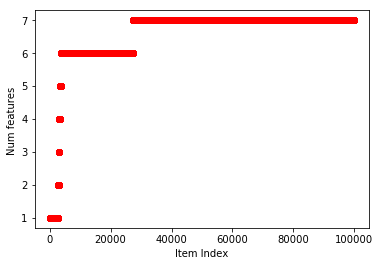

In [22]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

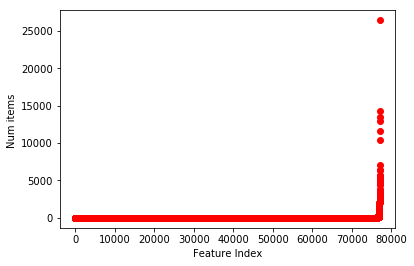

In [23]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

In [24]:
class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)

        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        print("Computing distance")
        dist = X * X.T
        print("Computed")

        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
#         co_counts = co_counts - scipy.sparse.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist

In [25]:
distance = Cosine(shrinkage=0)
# playlist_similarity = distance.compute(URM_with_params_idf)
playlist_similarity = distance.compute(URM_with_params.copy())

Normalized
Computing distance
Computed


In [26]:
distance = Cosine(shrinkage=0)
# playlist_similarity = distance.compute(URM_with_params_idf)
items_similarity_ICM = distance.compute(ICM.copy())

Normalized
Computing distance
Computed


In [27]:
distance = Cosine(shrinkage=0)
# playlist_similarity = distance.compute(URM_with_params_idf)
items_similarity_URM = distance.compute(URM.copy())

Normalized
Computing distance
Computed


In [28]:
SLIM_ISM = scipy.sparse.load_npz('./slim/prod_slim_150.npz')
print(type(SLIM_ISM))

<class 'scipy.sparse.csr.csr_matrix'>


In [29]:
# SLIM_ISM_csc = SLIM_ISM.tocsc()

print(type(items_similarity_URM))
print(type(playlist_similarity))

<class 'scipy.sparse.csc.csc_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>


In [30]:
class HybridRecommender:
    def __init__(self, k, to_predict=3):
        self.k = k
        self.to_predict = to_predict
    
    def fit(self, training_set, target_tracks, playlist_similarity, URM, items_similarity_ICM, items_similarity_URM, SLIM_ISM):
        self.training_set = training_set
        self.playlist_similarity = playlist_similarity
        self.items_similarity_ICM = items_similarity_ICM
        self.items_similarity_URM = items_similarity_URM
        self.SLIM_ISM = SLIM_ISM
        self.URM = check_matrix(URM, 'csc', dtype=np.float32)
        
        self.target_tracks_mask = np.zeros(self.items_similarity_ICM.shape[0])
        for value in list(target_tracks['transformed_track_id']):
            self.target_tracks_mask[value] = 1
    
    def recommend(self, target_playlists):
        def make_recommendation(playlist):
            tracks_on_playlist = self.training_set.loc[self.training_set['playlist_id'] == playlist['playlist_id']]
            transformed_tracks_on_playlist = track_id_le.transform(list(tracks_on_playlist['track_id']))
            tracks_on_playlist_mask = np.ones(self.items_similarity_ICM.shape[0])
            for value in transformed_tracks_on_playlist:
                tracks_on_playlist_mask[value] = 0

            # ContentBased similarity
            correlation = np.squeeze(np.asarray(self.items_similarity_ICM[:, transformed_tracks_on_playlist].mean(axis=1)))
            
            # ItemBased similarity
#             correlation_URM = np.squeeze(np.asarray(self.items_similarity_URM[:, transformed_tracks_on_playlist].sum(axis=1)))
#             correlation = correlation + correlation_URM * 0.0001
            
            # Slim similarity
            correlation_SLIM = np.squeeze(np.asarray(self.SLIM_ISM[:, transformed_tracks_on_playlist].mean(axis=1)))
            correlation = correlation + correlation_SLIM * 16
    
            # UserBased similarity
            similar_playlists = np.squeeze(self.playlist_similarity.getcol(playlist['transformed_playlist_id']).toarray())
            indices = np.argpartition(similar_playlists, -self.k)[-self.k:]
            ub_scores = np.take(similar_playlists, indices)
            correlation_UB = np.zeros(self.URM.shape[0])
            for index, score in zip(indices, ub_scores):
                correlation_UB += np.squeeze(self.URM.getcol(index).toarray()) * score
            
            correlation = correlation + correlation_UB * 0.18 / len(transformed_tracks_on_playlist)
            correlation = correlation * self.target_tracks_mask
            correlation = correlation * tracks_on_playlist_mask
            ind = np.argpartition(list(correlation), -self.to_predict)[-self.to_predict:]
            scores = np.take(correlation, ind)
        
            recommended_tracks = track_id_le.inverse_transform(ind)
            playlist['recommendation'] = list(reversed(recommended_tracks))
            playlist['scores'] = sorted(list(scores), reverse=True)
            return playlist
        recommended_items = target_playlists.apply(lambda playlist: make_recommendation(playlist), axis=1)
        return recommended_items


In [33]:
print('Building model...')
begin = time.time()
recommender = HybridRecommender(k=7, to_predict=5)
# recommender.fit(training_set, test_target_tracks, playlist_similarity, URM, items_similarity_ICM, items_similarity_URM, SLIM_ISM)
recommender.fit(train_final, target_tracks, playlist_similarity, URM, items_similarity_ICM, items_similarity_URM, SLIM_ISM)
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

Building model...
Took 0.03926s


In [35]:
print('Recommending...')
begin = time.time()
recommended_items = recommender.recommend(target_playlists)
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

print('recommended_items {}'.format(recommended_items.shape))
print(recommended_items.head(5))

Recommending...
Took 3595.97870s
recommended_items (10000, 4)
   playlist_id  transformed_playlist_id  \
0     10024884                    46297   
1     10624787                    50898   
2      4891851                    17907   
3      4267369                    14641   
4        65078                      537   

                                  recommendation  \
0    [1637241, 56817, 2971366, 3738046, 1320180]   
1   [3779369, 194963, 2781579, 1546826, 1980691]   
2   [2089117, 1371741, 2238571, 205321, 1406862]   
3  [2740798, 1890831, 1689809, 1712316, 3004539]   
4    [119305, 1742595, 2913000, 2512056, 431268]   

                                              scores  
0  [0.0164327062666, 0.0137192313607, 0.012401808...  
1  [0.0225384344293, 0.0185208265235, 0.018448000...  
2  [0.0556312093139, 0.0433824374088, 0.041438946...  
3  [0.0103156276162, 0.0102194677233, 0.009216206...  
4  [0.0155581170693, 0.0145458931644, 0.012703390...  


In [84]:
if not SUBMISSION:
    evaluate(recommended_items, validation_set)

Evaluating...
Precision: 0.10000, mAP: 0.10300, took 0.74419s


In [36]:
def print_results(recommended_items, filename):
    print('Printing...')
    with open('../submissions/hybrid4{}'.format(filename), 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, recommendation in recommended_items.iterrows():
            row = '{},'.format(recommendation['playlist_id'])
            for track_id in pd.Series(recommendation['recommendation']).values:
                row += ' {}'.format(track_id)
            row += '\n'
            output_file.write(row)
print_results(recommended_items, filename=SUBMISSION_FILENAME if SUBMISSION else TEST_FILENAME)

Printing...
